# Nov 29, Dec 3, 2023: HMM states on whole dataset

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product, combinations
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

from sklearn.decomposition import PCA
# networks
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
import ants
from nipype.interfaces import afni

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

In [3]:
args.parcel_name = 'whole'
COLLECT_path = f'/home/govindas/mouse_dataset/voxel/all_file_collections'
BASE_path = f'/home/govindas/mouse_dataset/roi'
TS_path = f'{BASE_path}/roi_timeseries_txt_files/{args.parcel_name}'
RES_path = f'/home/govindas/network_estimation/results/temp_states'

parcels_img = ants.image_read(
    (
        f'/home/govindas/mouse_dataset'
        f'/allen_atlas_ccfv3/hadi/parcellation'
        f'/warped_on_n162/{args.parcel_name}_parcels_warped_cm.nii.gz'
    )
)
parcels = parcels_img.numpy()

roi_labels = np.loadtxt(
    (
        f'/home/govindas/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
        f'/warped_on_n162/{args.parcel_name}_roi_labels.txt'
    )
)
roi_labels.shape

(1445,)

In [4]:
args.num_subs = 10
args.num_sess = 3
args.num_rois = len(np.loadtxt(
        (
            f'/home/govindas/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
            f'/warped_on_n162/{args.parcel_name}_roi_labels.txt'
        )
    ).astype(int)
)
args.tot_time = 600 # total time points

main_sample = [
    [
        []
        for ses in range(args.num_sess)
    ]
    for sub in range(args.num_subs)
]
for file in os.listdir(TS_path):
    fs = file.split('_')
    if int(fs[2].split('-')[-1]) % 2 == 0: continue # skip even runs
    sub = int(fs[0].split('-')[-1][-2:])
    ses = int(fs[1].split('-')[-1])
    # run = int(fs[2].split('-')[-1])
    main_sample[sub-1][ses-1].append(file)

for sub in np.arange(1,args.num_subs+1):
    for ses in np.arange(1, args.num_sess+1):
        main_sample[sub-1][ses-1] = list(np.sort(main_sample[sub-1][ses-1]))

In [5]:
def get_frame_censor_mask(run):
    identity = '_'.join(run.split('_')[:-1])
    collections_file = [f for f in os.listdir(COLLECT_path) if identity in f][0]
    with open(f'{COLLECT_path}/{collections_file}', 'r') as f:
        frm_csr_file = f.readlines()[0][:-1]
    with open(frm_csr_file, 'r') as f:
        frm_csr =  np.array([(v[:-1]) == 'True' for v in f.readlines()[1:]])
    return frm_csr

In [6]:
ts_all = []
mask_all = []
for sub, ses in tqdm(product(range(args.num_subs), range(args.num_sess))):
    for run in main_sample[sub][ses]:
        ts = np.loadtxt(f'{TS_path}/{run}')
        ts = stats.zscore(ts, axis=0, nan_policy='omit') # time x rois
        ts = np.nan_to_num(ts)
        mask = get_frame_censor_mask(run)
        ts_big = np.zeros((args.tot_time, args.num_rois))
        ts_big[mask, :] = ts
        ts_all.append(ts_big)
        mask_all.append(np.tile(mask[None, :].T, (1, args.num_rois))) # tot_time x rois

30it [00:07,  3.86it/s]


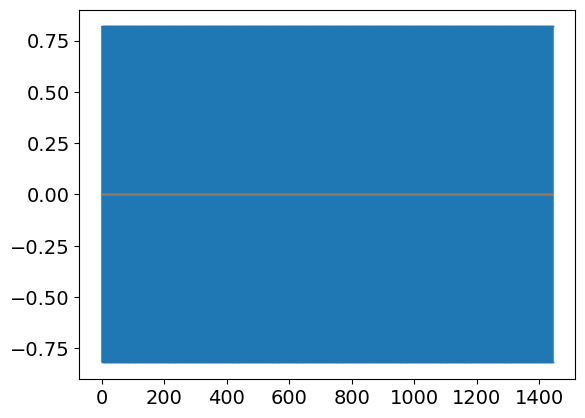

In [8]:
run = 98
plt.errorbar(x=range(args.num_rois), y=np.mean(ts_all[run], axis=0), yerr=np.std(ts_all[run], axis=0), alpha=0.5)
plt.plot(range(args.num_rois), np.mean(ts_all[run], axis=0), alpha=1.0)

In [7]:
args.var = 0.8 # variance explained
try:
    with open(f'/home/govindas/network_estimation/results/temp_states/pca_tss_v{10*args.var:1n}.pkl', 'rb') as f:
        [pca, ts_, tss_] = pickle.load(f)
        args.num_comps = ts_.shape[-1]
        print(ts_.shape)
except:
    # find the suitable # of components to explain args.var variance in data
    pca = PCA(n_components=args.num_rois) 
    pca = pca.fit(ts)
    c = np.cumsum(pca.explained_variance_ratio_)
    d = np.max(np.where(c <= args.var)[0])
    
    # fresh pca with found num. comps.
    pca = PCA(n_components=d)
    pca = pca.fit(ts)
    ts_ = pca.transform(ts)
    print(ts_.shape)

    tss_ = []
    ends = np.cumsum(np.vstack(ts_shapes)[:, 0])
    for idx_e, e in enumerate(ends):
        s = ends[idx_e-1] if idx_e > 0 else 0
        tss_.append(ts_[s:e, :])

    for i in range(len(tss)):
        assert tss[i].shape[0] == tss_[i].shape[0]
        
    with open(f'/home/govindas/network_estimation/results/temp_states/pca_tss_v{10*args.var:1n}.pkl', 'wb') as f:
        pickle.dump([pca, ts_, tss_], f)
    
    args.num_comps = ts_.shape[-1]
    assert args.num_comps == d

(56701, 557)


  0%|          | 0/25 [00:00<?, ?it/s]

D = 557, K = 5


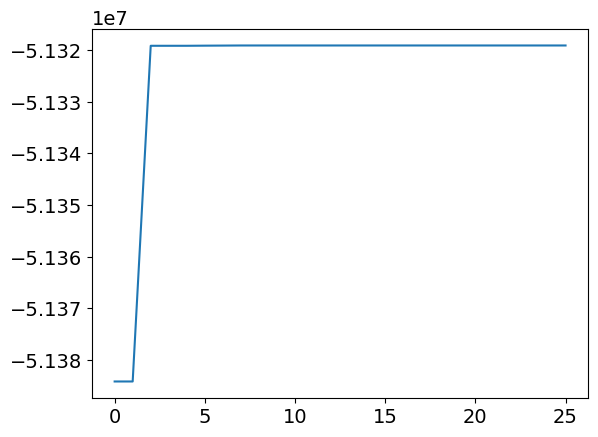

In [8]:
args.N_iters = 25
args.transitions = 'standard'
args.observations = 'ar'
for args.num_states in range(5, 6):
    try:
        with open(
            (
                f'/home/govindas/network_estimation/results/temp_states'
                f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
            ), 
            'rb'
        ) as f:
            hmm = pickle.load(f)
    except:
        hmm = ssm.HMM(
            K=args.num_states,
            D=args.num_comps,
            transitions=args.transitions,
            observations=args.observations,
        )
        lls = hmm.fit(
            tss_, 
            method='em', 
            num_iters=args.N_iters, 
            init_method='kmeans',
        )
        print(f'D = {args.num_comps}, K = {args.num_states}')
        with open(
            (
                f'/home/govindas/network_estimation/results/temp_states'
                f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
            ), 
            'wb'
        ) as f:
            pickle.dump(hmm, f)
        plt.plot(lls)

---

In [9]:
args.num_states = 5
with open(
    (
        f'/home/govindas/network_estimation/results/temp_states'
        f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
    ), 
    'rb'
) as f:
    hmm = pickle.load(f)

Text(0.5, 1.0, 'state transition probs.')

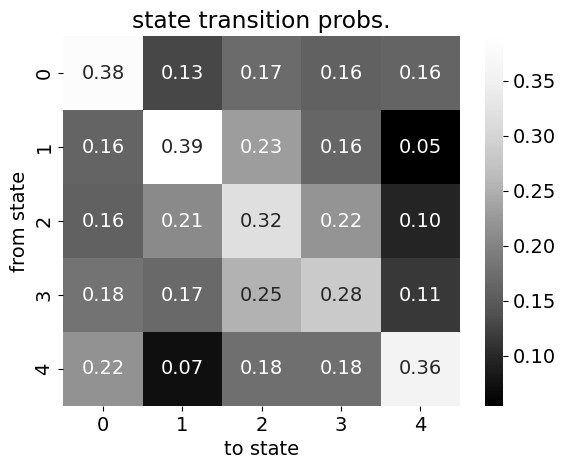

In [10]:
# visualize state transiton matrix
sns.heatmap(hmm.transitions.transition_matrix, cmap='Greys_r', annot=True, fmt='.2f')
plt.xlabel('to state')
plt.ylabel('from state')
plt.title('state transition probs.')

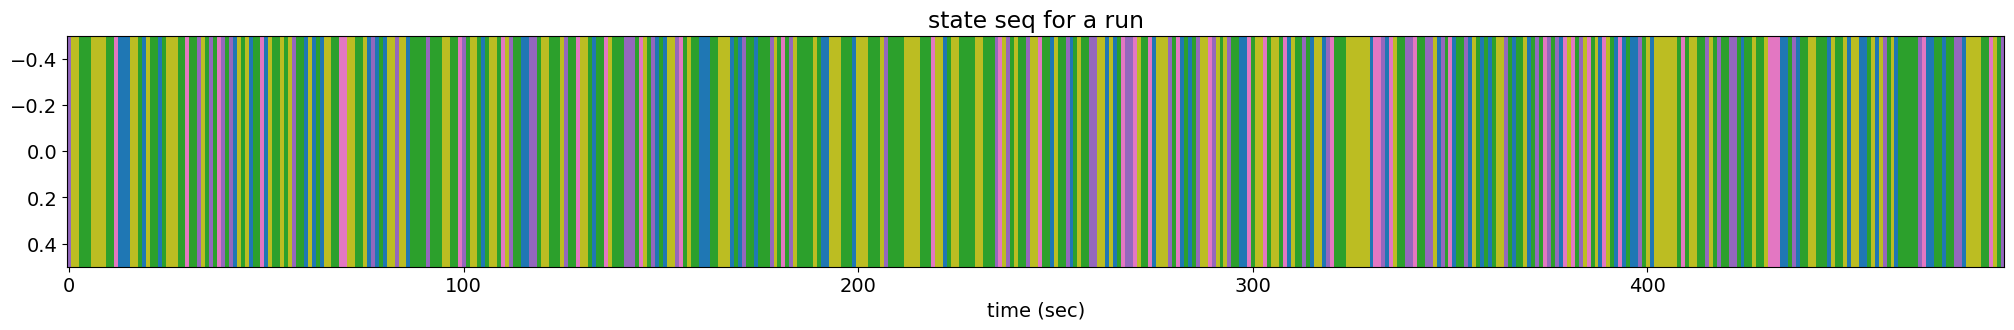

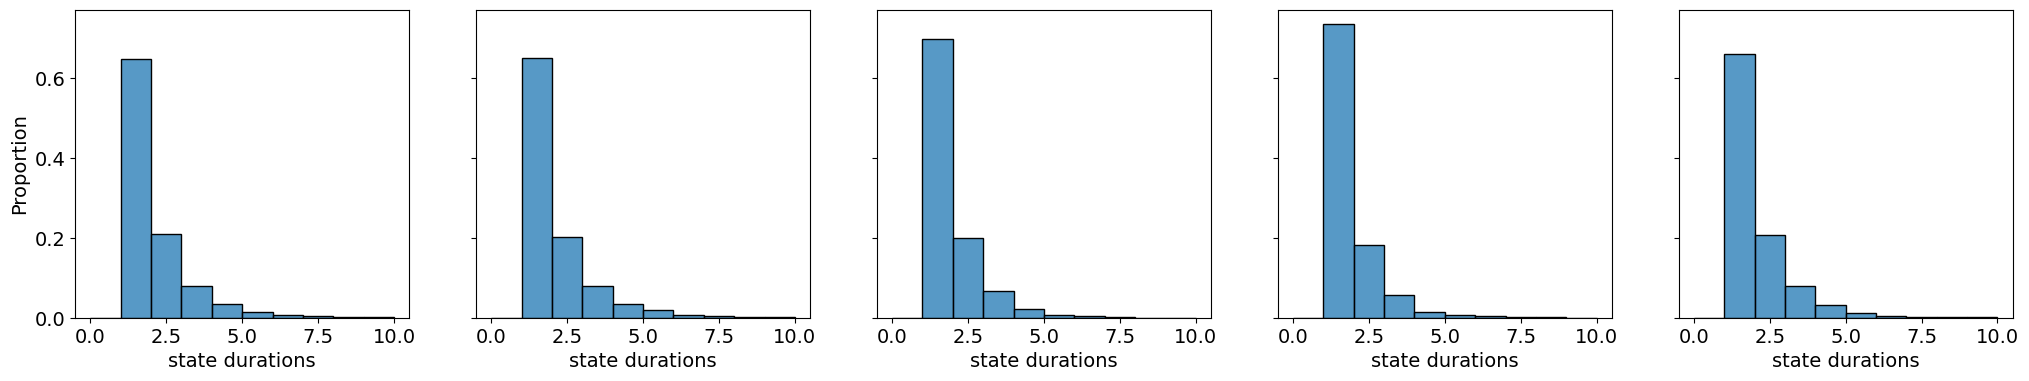

In [36]:
# state sequence
plt.figure(figsize=(25, 3))
plt.imshow(
    hmm.most_likely_states(tss_[27])[None, :], 
    aspect='auto',
    cmap='tab10',
    vmin=0, 
    vmax=args.num_states,
)
plt.title('state seq for a run')
plt.xlabel('time (sec)')


state_seq = hmm.most_likely_states(ts_)
durs_stacked = [[] for _ in range(args.num_states)]
st_list, durs = ssm.util.rle(state_seq)
for s in range(args.num_states):
    durs_stacked[s] = durs[st_list == s]
    
nrows, ncols = int(args.num_states // 5), 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
for idx_state in range(args.num_states):
    r, c = idx_state // 5,  idx_state % 5
    ax = axs[r, c] if args.num_states > 5 else axs[c]
    
    sns.histplot(durs_stacked[idx_state], stat='proportion', binwidth=1, binrange=[0, 10], ax=ax)
    ax.set(xlabel='state durations')

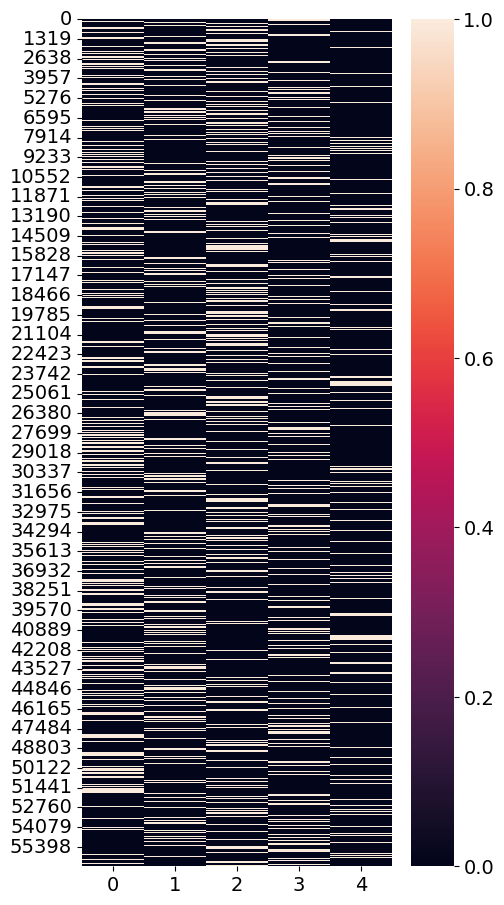

In [42]:
# glm for finding mean activation for each state
regressors = np.stack([state_seq == s for s in range(hmm.K)], axis=-1)
fig, axs = plt.subplots(1, 1, figsize=(5, 11))
sns.heatmap(regressors, ax=axs)

with open(f'/home/govindas/network_estimation/results/temp_states/roi_timeseries.txt', 'wb') as f:
    np.savetxt(f, ts)

with open(f'/home/govindas/network_estimation/results/temp_states/state_regs.txt', 'wb') as f:
    np.savetxt(f, regressors)

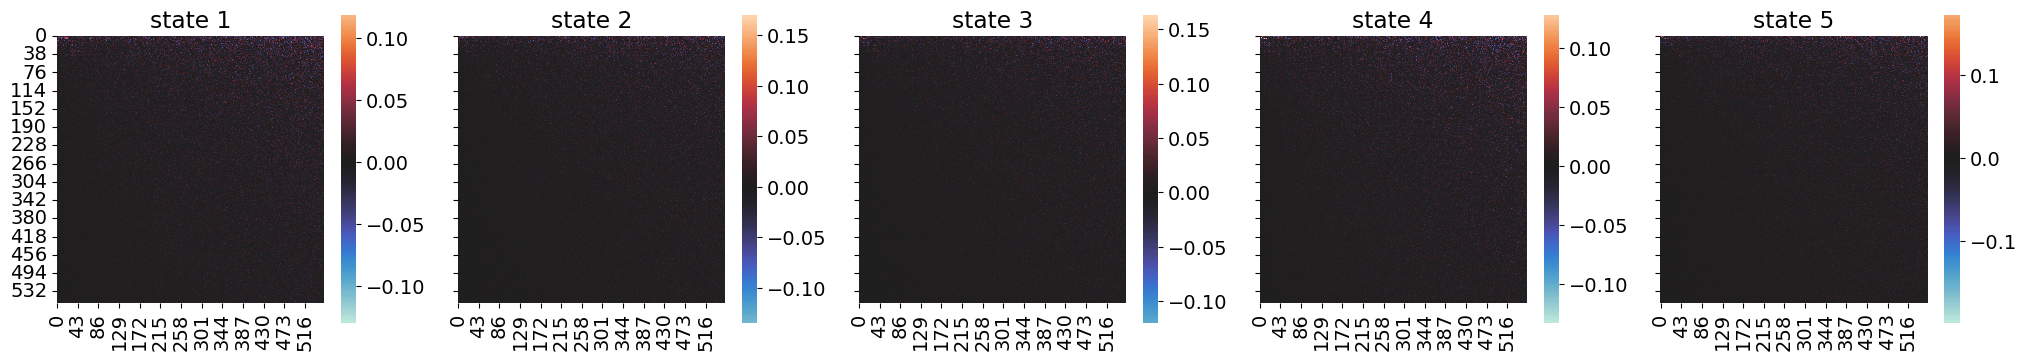

In [27]:
# sigmas / As
if args.observations in ['gaussian']:
    sigmas = hmm.observations.Sigmas
elif args.observations in ['ar', 'autoregessive', 'robust_ar']:
    sigmas = hmm.observations.As

nrows, ncols = int(args.num_states // 5), 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
for idx_state in range(args.num_states):
    r, c = idx_state // 5,  idx_state % 5
    ax = axs[r, c] if args.num_states > 5 else axs[c]
    p = sigmas[idx_state]
    # p = np.log(p)
    p -= np.diag(np.diag(p))
    sns.heatmap(p, ax=ax, square=True, center=0)# vmin=-15, vmax=3)
    ax.set(title=f'state {idx_state+1}')

[Text(0.5, 1.0, 'bs')]

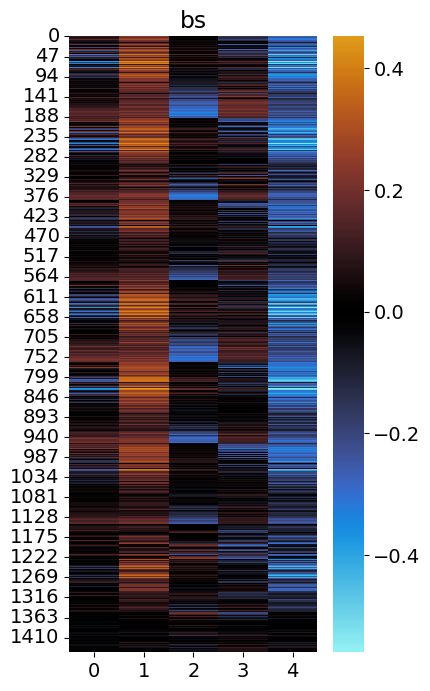

In [25]:
# mus
if args.observations in ['ar']:
    mus = hmm.observations.bs
    title = 'bs'
elif args.observations in ['gaussian']:
    mus = hmm.observations.mus
    title = 'mus'

mus = pca.inverse_transform(mus).T
fig, axs = plt.subplots(1, 1, figsize=(4, 8))
ax = axs
sns.heatmap(mus, ax=ax, cmap=cmr.iceburn, center=0, )
ax.set(title=title)

In [ ]:
for idx_state in range(args.num_states):
    states_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels.astype(int)):
        states_img += (parcels == roi) * mus[idx, idx_state]

    parcels_img.new_image_like(
        states_img
    ).to_filename(f'{RES_path}/state{idx_state}.nii.gz')

out_file = f'{RES_path}/state_mean_activations_{args.parcel_name}_v{args.var}_k{args.num_states}.nii.gz'
try:
    os.remove(out_file)
except:
    pass

tcat = afni.TCat()
tcat.inputs.in_files = [
    f'{RES_path}/state{idx_state}.nii.gz'
    for idx_state in range(args.num_states)
]
tcat.inputs.out_file = out_file
tcat.inputs.rlt = ''
tcat.cmdline
res = tcat.run()

for idx_state in range(args.num_states):
    try:
        os.remove(f'{RES_path}/state{idx_state}.nii.gz')
    except:
        pass

231204-14:05:07,301 nipype.interface INFO:
	 stderr 2023-12-04T14:05:07.301681:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
231204-14:05:07,304 nipype.interface INFO:
	 stderr 2023-12-04T14:05:07.304769:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
231204-14:05:07,306 nipype.interface INFO:
	 stderr 2023-12-04T14:05:07.305987:*+ WARNING: Set TR of output dataset to 1.0 s
231204-14:05:07,369 nipype.interface INFO:
	 stderr 2023-12-04T14:05:07.369400:++ elapsed time = 0.1 s


---